In [2]:
import torch
import geomloss
import torch.nn.functional as F
from geomloss import SamplesLoss
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# --- Fonctions utilitaires ---

def _downsample_to_resolution(img: torch.Tensor, target_res):
    """
    img : (3, H, W)
    target_res :
      - int   -> on fixe le plus grand côté à target_res (ratio conservé)
      - tuple -> (H_target, W_target) directement
    """
    C, H, W = img.shape
    assert C == 3

    if isinstance(target_res, int):
        max_side = max(H, W)
        if max_side == target_res:
            return img
        scale = target_res / max_side
        new_H = max(1, int(round(H * scale)))
        new_W = max(1, int(round(W * scale)))
        size = (new_H, new_W)
    else:
        # on suppose (H_target, W_target)
        size = target_res

    img_b = img.unsqueeze(0)  # (1,3,H,W)
    img_ds = F.interpolate(img_b, size=size, mode="bilinear", align_corners=False)
    return img_ds.squeeze(0)  # (3, H_new, W_new)


def _channel_to_measure(img_c: torch.Tensor, device=None):
    """
    img_c : (H, W), intensités >= 0 (ex: 0–255 ou 0–1)
    Retourne :
      - positions : (N, 2) dans [0,1]^2
      - weights   : (N,) (non normalisées)
    """
    if device is None:
        device = img_c.device

    H, W = img_c.shape
    ys = torch.linspace(0.0, 1.0, H, device=device)
    xs = torch.linspace(0.0, 1.0, W, device=device)
    yy, xx = torch.meshgrid(ys, xs, indexing="ij")  # (H,W)

    positions = torch.stack([xx, yy], dim=-1).reshape(-1, 2)  # (N,2)
    weights = img_c.reshape(-1).clamp(min=0)

    return positions, weights


def rgb_unbalanced_sinkhorn(
    img1: torch.Tensor,
    img2: torch.Tensor,
    res1,
    res2,
    blur=0.02,
    reach=0.1,
    p=2,
    debias=True,
    return_potentials=False,
    device="cpu",
    backend="tensorized",
):
    """
    img1, img2 : torch.Tensor
        - soit (H, W, 3)
        - soit (3, H, W)
        valeurs >= 0 (0–1 ou 0–255), on ne normalise pas les intensités.
    res1 : résolution pour img1 (int ou (H1,W1))
    res2 : résolution pour img2 (int ou (H2,W2))
    blur  : sigma telle que eps = blur^p
    reach : tau telle que rho = reach^p  (unbalanced)
    p     : exponent du coût (1 ou 2 en pratique)
    debias : utilise la Sinkhorn divergence dé-biaisée
    return_potentials : si True, retourne aussi (f,g) par canal
    backend : "tensorized", "online", etc. (ici "tensorized" par défaut)
    Retour :
      {
        "losses": {
            "R": float,
            "G": float,
            "B": float,
        },
        "potentials": None
           ou {
               "R": {"f1": (H1_res1,W1_res1), "g2": (H2_res2,W2_res2)},
               "G": {...},
               "B": {...},
           }
      }
    """

    # Mise en forme des images
    if img1.dim() == 3 and img1.shape[-1] == 3:
        img1 = img1.permute(2, 0, 1)  # (3,H,W)
    if img2.dim() == 3 and img2.shape[-1] == 3:
        img2 = img2.permute(2, 0, 1)

    img1 = img1.to(device).float()
    img2 = img2.to(device).float()

    assert img1.shape[0] == 3 and img2.shape[0] == 3, "Images must be RGB (3 channels)."

    # Downsample à la résolution demandée
    img1_ds = _downsample_to_resolution(img1, res1)  # (3,H1r,W1r)
    img2_ds = _downsample_to_resolution(img2, res2)  # (3,H2r,W2r)

    C1, H1r, W1r = img1_ds.shape
    C2, H2r, W2r = img2_ds.shape
    assert C1 == 3 and C2 == 3

    colors = ["R", "G", "B"]
    losses = {c: 0.0 for c in colors}
    potentials = {} if return_potentials else None

    # On crée une factory de loss pour pouvoir activer ou non potentials
    def make_loss(potentials_flag: bool):
        return SamplesLoss(
            loss="sinkhorn",
            p=p,
            blur=blur,
            reach=reach,
            # On ne débiaise pas pour récupérer les potentiels
            debias=debias and not potentials_flag,
            backend=backend,
            potentials=potentials_flag,
        )

    # --- Calcul des coûts par canal ---
    for ch_idx, color in enumerate(colors):
        ch1 = img1_ds[ch_idx]  # (H1r,W1r)
        ch2 = img2_ds[ch_idx]  # (H2r,W2r)

        x1, a1 = _channel_to_measure(ch1, device=device)
        x2, a2 = _channel_to_measure(ch2, device=device)

        loss_fn = make_loss(potentials_flag=False)
        cost_val = loss_fn(a1, x1, a2, x2)  # scalaire
        losses[color] = float(cost_val.detach().cpu())

        if return_potentials:
            loss_fn_pot = make_loss(potentials_flag=True)
            F_chan, G_chan = loss_fn_pot(a1, x1, a2, x2)  # (N1,), (N2,)

            f_map = F_chan.view(H1r, W1r)
            g_map = G_chan.view(H2r, W2r)

            potentials[color] = {
                "f1": f_map.detach().cpu(),  # potentiels sur img1 (canal)
                "g2": g_map.detach().cpu(),  # potentiels sur img2 (canal)
                "H1": H1r,
                "W1": W1r,
                "H2": H2r,
                "W2": W2r,
                "x1": x1,
                "a1": a1,
                "x2": x2,
                "a2": a2,
            }

    return {
        "losses": losses,
        "potentials": potentials,
    }

In [4]:
# --- Fonctions de reconstruction ---

def reconstruct_pi_unbalanced(x1, a1, x2, a2, f, g, blur, p, reach):
    """
    x1 : (N1, 2) positions image 1
    a1 : (N1,) poids image 1 (intensités)
    x2 : (N2, 2) positions image 2
    a2 : (N2,) poids image 2
    f  : (N1,) potentiel OT sur image 1 (debias=False)
    g  : (N2,) potentiel OT sur image 2
    blur : sigma => eps = sigma^p
    p : exponent de coût
    reach : tau (non utilisé ici, mais gardé pour la cohérence de l'API)

    Retour :
      pi : (N1, N2) plan de transport exact OT_eps,rho
    """

    # eps et rho
    eps = blur**p
    # rho = reach**p # Non requis pour reconstruire pi selon Eq. 8

    # Matrice de coûts C (N1,N2)
    # coût standard de GeomLoss : 1/p ||x-y||^p
    diff = x1[:, None, :] - x2[None, :, :]
    C = (diff.norm(dim=-1) ** p) / p

    # Terme exp((f_i + g_j - C_ij)/eps)
    K = torch.exp((f[:, None] + g[None, :] - C) / eps)

    # Le plan est K * (alpha * beta) [cf. Eq. 8 / 205 de l'article]

    pi = K * a1[:, None] * a2[None, :]

    return pi


def reconstruct_image_from_pi(pi, H2, W2):
    """
    Reconstruit la masse de la marginale 2 (la simple somme)
    pi : (N1, N2)
    H2, W2 : taille de l'image 2 (celle où vivent les j indices)

    Retour :
      img_reconstructed : (H2, W2)
    """
    N2 = H2 * W2
    assert pi.shape[1] == N2, "Dimension mismatch for reconstruction"

    # somme des colonnes = intensité transportée au pixel j
    rec = pi.sum(dim=0)  # (N2,)
    rec = rec.view(H2, W2)
    return rec


def reconstruct_barycentric(pi, a1, H2, W2):
    """
    Reconstruit l'image 2 par projection barycentrique des intensités de l'image 1.
    pi : (N1, N2) plan de transport
    a1 : (N1,) vecteur des intensités/couleurs de l'image 1
    H2, W2 : taille de l'image 2 (cible)
    """
    # a1 est le vecteur (N1,) des intensités/couleurs source
    num = (pi * a1[:, None]).sum(dim=0)  # (N2,)
    den = pi.sum(dim=0) + 1e-12  # Masse totale arrivant en j

    rec = num / den
    return rec.view(H2, W2)


def reconstruct_image_via_unbalanced_ot(
    img1,
    img2,
    res1,
    res2,
    blur=0.02,
    reach=0.1,
    p=2,
    debias=True,  # Note : sera ignoré pour les potentiels
    device="cpu",
    backend="tensorized",
):

    # 1. Un seul appel au calcul OT unbalanced + potentiels + mesures
    out = rgb_unbalanced_sinkhorn(
        img1,
        img2,
        res1=res1,
        res2=res2,
        blur=blur,
        reach=reach,
        p=p,
        debias=debias,  # debias=True pour la loss, mais False pour les potentiels
        return_potentials=True,
        device=device,
        backend=backend,
    )

    losses = out["losses"]
    pots = out["potentials"]

    if pots is None:
        raise ValueError("return_potentials=True a échoué.")

    H2 = pots["R"]["H2"]
    W2 = pots["R"]["W2"]

    img_rec = torch.zeros(3, H2, W2, device=device)

    # eps = blur ** p # Transmis à la fonction de reconstruction
    # rho = reach ** p

    for c_idx, color in enumerate(["R", "G", "B"]):

        pot = pots[color]

        # --- Potentiels exacts (compatibles x1/x2)
        f1 = pot["f1"].reshape(-1).to(device)
        g2 = pot["g2"].reshape(-1).to(device)

        # --- Les mesures exactes utilisées dans Sinkhorn
        x1 = pot["x1"].to(device)
        a1 = pot["a1"].to(device)

        x2 = pot["x2"].to(device)
        a2 = pot["a2"].to(device)

        # --- Reconstruction du plan π
        pi = reconstruct_pi_unbalanced(
            x1, a1, x2, a2, f1, g2, blur=blur, p=p, reach=reach
        )

        # --- Reconstruction barycentrique: couleur = moyenne des couleurs src
        #     pondérée par π_ij / sum(π_·j)
        # On utilise a1 (le vecteur d'intensité N1) comme "couleur" à transporter
        rec = reconstruct_barycentric(pi, a1, H2, W2)
        img_rec[c_idx] = rec

    return {
        "losses": losses,
        "reconstructed": img_rec.clamp(0).cpu(),
        "potentials": pots,
    }

Using device: cpu


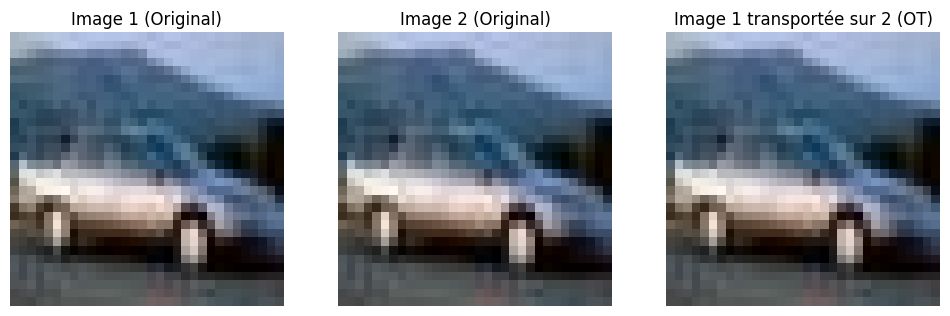


Sinkhorn UOT losses per channel :
  R: 0.000000
  G: 0.000000
  B: 0.000000


In [ ]:
# --- 0. Définir le device ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# --- 1. Charger les images ---
try:
    img1_pil = Image.open("../data/cifar10/automobile/0000.jpg").convert("RGB")
    img2_pil = Image.open("../data/cifar10/automobile/0000.jpg").convert("RGB")
except FileNotFoundError:
    print("Erreur: Fichier image non trouvé. Assurez-vous que le chemin est correct.")
    # Créer des images dummy pour que le script tourne
    img1_pil = Image.fromarray(np.random.randint(0, 256, (32, 32, 3), dtype=np.uint8))
    img2_pil = Image.fromarray(np.random.randint(0, 256, (32, 32, 3), dtype=np.uint8))


# Convertir en tensor PyTorch (H,W,3) -> (3,H,W)
img1_raw = torch.from_numpy(np.array(img1_pil)).permute(2, 0, 1)
img2_raw = torch.from_numpy(np.array(img2_pil)).permute(2, 0, 1)

# --- 2. Appeler la reconstruction OT unbalanced ---
out = reconstruct_image_via_unbalanced_ot(
    img1_raw,
    img2_raw,
    res1=32,
    res2=32,
    blur=0.01,  # Flou (epsilon)
    reach=None,  # Portée (rho)
    p=2,
    debias=True,  # debias pour la loss, mais pas pour les potentiels
    device=DEVICE,
)

# Récupérer l'image reconstruite (3,H,W)
img_rec = out["reconstructed"]  # intensités reconstruites

# Normaliser pour l'affichage (si les intensités d'origine ne sont pas 0-1)
# Si vos images sont 0-255, la reconstruction barycentrique est aussi 0-255
if img1_raw.max() > 1.0:
    img_rec = img_rec / 255.0

img_rec = img_rec.clamp(min=0, max=1.0)  # sécurité
img_rec_np = img_rec.permute(1, 2, 0).numpy()

# Normaliser les images originales pour affichage si nécessaire
img1_np = img1_raw.permute(1, 2, 0).numpy()
img2_np = img2_raw.permute(1, 2, 0).numpy()
if img1_np.max() > 1.0:
    img1_np = img1_np / 255.0
if img2_np.max() > 1.0:
    img2_np = img2_np / 255.0


# --- 3. Afficher ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Image 1 (Original)")
plt.imshow(img1_np)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Image 2 (Original)")
plt.imshow(img2_np)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Image 1 transportée sur 2 (OT)")
plt.imshow(img_rec_np)
plt.axis("off")

plt.show()

# --- Affichage des valeurs de coût par canal ---
print("\nSinkhorn UOT losses per channel :")
for c, v in out["losses"].items():
    print(f"  {c}: {v:.6f}")